<a href="https://colab.research.google.com/github/murdockbleak/NN-Compression/blob/main/Low_Rank_Neural_Network_Compression_seminar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN compression tutorial

In this notebook we will go through the process of CNN compression.

## Brief reminder: 

### Why do we need CNN compression?

- To reduce disk space consumption
- To accelerate model inference
- To reduce energy consumption

### CNN compression pipeline

1) Extract convolutional layer from pretrained CNN

2) Decompose it with tensor decomposition method

3) Replace initial convolutional layer with factorized layer

4) Fine-tune model to recover performance degradation


## Let's go through all of the stages in the pipeline

# 1. Load ResNet for Cifar100


## ResNet-18

At a high level, ResNet-18 (ResNet-18) is organized in a following way:

(i) ResNet basic block that consists of 2 3x3 convolutions followed by BatchNorm layers and ReLU non-linearity

(ii) skip connections that works as aggregation of basic block input and output features ($X_{out} = X_{in} + BasicBlock(X_{in})$)

(iii) Basic blocks are sequentially connected with 1 conv layer in the beginning and average pooling in the end. Together they form a feature extraction block

(iv) a fully connected layer in the end that performs a linear multiclass classification based on extracted features;
The architecture is summarized in :numref:`img_lenet`.

![Data flow in LeNet. The input is a handwritten digit, the output a probability over 10 possible outcomes.](https://i.imgur.com/XwcnU5x.png)
:label:`ResNet-18 scheme`

In [ ]:
!pip install torch torchvision tensorly==0.4.5 flopco-pytorch

     |████████████████████████████████| 70 kB 2.2 MB/s 
     |████████████████████████████████| 154 kB 10.6 MB/s 
  Created wheel for tensorly: filename=tensorly-0.4.5-py3-none-any.whl size=100163 sha256=0666400160fb7e27b70c830c4589f396e35663dd379d3f4ca107fc57b0e980a9
  Stored in directory: /root/.cache/pip/wheels/05/ed/36/493bba3faa150a1193eec864db4951355eb64659330cb00722
Successfully built tensorly


In [ ]:
!gdown --id 1zFqrlK2WDPzZw5EyrjdOB-UWt5xOj-iS
!tar -xf arxiv.tar
!ls

Downloading...
From: https://drive.google.com/uc?id=1zFqrlK2WDPzZw5EyrjdOB-UWt5xOj-iS
To: /content/arxiv.tar
100% 45.0M/45.0M [00:00<00:00, 208MB/s]
arxiv.tar		 pruning_utils.py  sample_data
cifar100-resnet18_8x.pt  resnet_8x.py	   utils.py


In [ ]:
#Import Libraries

import numpy as np

from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import torch.optim as optim

import tensorly as tl
from tensorly.random import random_kruskal
from tensorly.tenalg import khatri_rao
from tensorly.decomposition import parafac
from flopco import FlopCo

from resnet_8x import ResNet18_8x
from utils import batchnorm_callibration, get_validation_scores, fix_random_seed, get_cifar100_dataloader

import copy
import matplotlib.pyplot as plt

%matplotlib inline

tl.set_backend('pytorch')

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
model = ResNet18_8x(num_classes=100)
model.load_state_dict(torch.load("cifar100-resnet18_8x.pt"))

<All keys matched successfully>

In [ ]:
dataset_path = './'
batch_size = 256
num_workers = 0

train_loader, val_loader = get_cifar100_dataloader(dataset_path, batch_size, num_workers, download=True)
calibrate_batches = 200

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting ./cifar-100-python.tar.gz to ./
Files already downloaded and verified


In [ ]:
model.to(device)
top1_acc_orig, top5_acc_orig = get_validation_scores(model, val_loader, device=device)
print(f'Original model. Top 1 acc: {top1_acc_orig:.3f}, Top 5 acc: {top5_acc_orig:.3f}')

  0%|          | 0/40 [00:00<?, ?it/s]

Original model. Top 1 acc: 0.771, Top 5 acc: 0.936


In [ ]:
def get_layer_by_name(model, mname):
    '''
    Extract layer using layer name
    '''
    module = model
    mname_list = mname.split('.')
    for mname in mname_list:
        module = module._modules[mname]

    return module


def replace_conv_layer_by_name(model, mname, new_layer):
    '''
    Replace layer using layer name
    '''
    module = model
    mname_list = mname.split('.')
    for mname in mname_list[:-1]:
        module = module._modules[mname]
    module._modules[mname_list[-1]] = new_layer

def train(model, device, train_loader, optimizer):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()

# 2. Compress Fully Connected layer

Linear layer: $Y = X W^T + b$

Singular Value decomposition: $W = U \Sigma V^T$

We use truncated SVD with rank $r$: $U_r = U[:, :r], \Sigma_r = Σ[:r, :r], V_r = V[:, :r]$

Since $\Sigma_r$ is a diagonal matrix of shape $r \times r$, we can fuze it inside $U_r$ and $V_r$ in order to avoid multiplication of X with it during inference time:

$ W_2 = U[:, :r] \sqrt{\Sigma_r}, W_1 = \sqrt{\Sigma_r} U[:, :r]^T$

As a result, we get:

$W ≈ W_2 W_1$ and $Y \approx X W_1^T W_2^T + b$

Which is equivalent to two sequential linear layers - first with weight $W_1$ and zero bias and the second one with weight $W_2$ and bias $b$.

Let $W$ have $n_{in}, n_{out}$ shape.

Then, FLOP number of initial linear layer is $2 \times n_{in} \times (n_{out} + 1)$.

And FLOP number of factorized layer is $2 \times n_{in} \times r + r \times (2 \times n_{out} + 1). $

If $r < \frac{n_{in} \times (n_{out} + 1)}{n_{in} +  n_{out} + 0.5}$, then complexity of factorized layer is lower.

## 2.1. Implement the factorized layer

In [ ]:
# extract weight matrix and bias
fc_w = model.linear.weight.data.cpu().data.numpy()
fc_b = model.linear.bias.data.cpu().data.numpy()
fc_w.shape, fc_b.shape

((100, 512), (100,))

In [ ]:
# get SVD of W
U, S, Vt = np.linalg.svd(fc_w, full_matrices=False)


# truncate SVD and fuse Sigma matrix

rank = 10

w1 = np.dot(np.diag(np.sqrt(S[0:rank])),Vt[0:rank, :])
w2 = np.dot(U[:, 0:rank], np.diag(np.sqrt(S[0:rank])))


# create new layers and insert weights
out_features, in_features = fc_w.shape
is_bias = model.linear.bias is not None 

linear1 = nn.Linear(in_features = in_features, 
                      out_features = rank,
                      bias = False)
linear1.weight = nn.Parameter(torch.FloatTensor(w1))

linear2 = nn.Linear(in_features = rank,
                      out_features = out_features,
                      bias=is_bias)
linear2.weight = nn.Parameter(torch.FloatTensor(w2))
linear2.bias = nn.Parameter(torch.FloatTensor(fc_b))

# create factorized layer
factorized_layer = nn.Sequential(linear1, linear2)

In [ ]:
compressed_model = copy.deepcopy(model)
compressed_model.linear = factorized_layer

In [ ]:
compressed_model.to(device)
top1_acc, top5_acc = get_validation_scores(compressed_model, val_loader, device=device)
print(f'Compressed model. Top 1 acc: {top1_acc:.3f}, Top 5 acc: {top5_acc:.3f}')

  0%|          | 0/40 [00:00<?, ?it/s]

Compressed model. Top 1 acc: 0.381, Top 5 acc: 0.796


In [ ]:
factorized_layer

Sequential(
  (0): Linear(in_features=512, out_features=10, bias=False)
  (1): Linear(in_features=10, out_features=100, bias=True)
)

**It is more convenient to implement operation of layer compression and factorized layer creation in one class. See the details below**

In [ ]:
class SVD_linear_layer(torch.nn.Module):
    def __init__(self, layer, rank=None, rank_selection='manual'):
        super(SVD_linear_layer, self).__init__()
        
        self.in_features = layer.in_features
        self.out_features = layer.out_features
        self.is_bias = layer.bias is not None 
        if self.is_bias:
            self.bias = layer.bias
            
        if rank is None or type(rank) is not int:
            raise AttributeError('Rank should be an integer number')
        else:
            self.rank = rank
            
            
        self.svd_decomposition = self.__replace__(layer)
        
    def __replace__(self, layer):
        """ Gets a linear layer and a target rank, 
            returns a nn.Sequential object with
            each layer representing a decomposed factor"""
        weight = layer.weight.data.cpu().data.numpy()
        
        U, S, Vt = np.linalg.svd(weight, full_matrices=False)
        w0 = np.dot(np.diag(np.sqrt(S[0:self.rank])),Vt[0:self.rank, :])
        w1 = np.dot(U[:, 0:self.rank], np.diag(np.sqrt(S[0:self.rank])))
        new_kernels = [torch.FloatTensor(w0),
                       torch.FloatTensor(w1)]
        
        new_layers = [
            nn.Linear(in_features = self.in_features, 
                      out_features = self.rank,
                      bias = False),
            nn.Linear(in_features = self.rank,
                      out_features = self.out_features,
                      bias=self.is_bias)
        ]
        
        with torch.no_grad():
            for i in range(len(new_kernels)):
                new_layers[i].weight = nn.Parameter(new_kernels[i].cpu())
                if i == len(new_kernels)-1 and self.is_bias:
                    new_layers[i].bias = nn.Parameter(self.bias)
                    
        return nn.Sequential(*new_layers)
        
    def forward(self, x):
        out = self.svd_decomposition(x)
        return out

In [ ]:
compressed_model = copy.deepcopy(model)

factorized_layer = SVD_linear_layer(model.linear, rank=10)
compressed_model.linear = factorized_layer

In [ ]:
compressed_model.to(device)
top1_acc, top5_acc = get_validation_scores(compressed_model, val_loader, device=device)
print(f'Compressed model. Top 1 acc: {top1_acc:.3f}, Top 5 acc: {top5_acc:.3f}')

  0%|          | 0/40 [00:00<?, ?it/s]

Compressed model. Top 1 acc: 0.381, Top 5 acc: 0.796


## 2.2 Decomposition rank

Decomposition rank is the parameter that defines the balance between compression ratio and accuracy drop of the model.

Let's change the decomposition rank and see how it affects the performance of the model

In [ ]:
stats_orig = FlopCo(model, img_size = (1, 3, 32, 32), device=device)

In [ ]:
stats_orig.flops['linear'][0]

102912

In [ ]:
compressed_model = copy.deepcopy(model)

rank_list = [1, 5, 10, 15, 20, 25, 30, 40, 50, 65, 80, 100]
acc_list = []
cr_list = []




for rank in rank_list:
  factorized_layer = SVD_linear_layer(model.linear, rank=rank)
  compressed_model.linear = factorized_layer


  compressed_model.to(device)
  top1_acc, top5_acc = get_validation_scores(compressed_model, val_loader, device=device)
  acc_list.append(top1_acc)

  stats_compr = FlopCo(compressed_model, img_size = (1, 3, 32, 32), device=device)
  cr_list.append((stats_compr.flops['linear.svd_decomposition.0'][0]+
                  stats_compr.flops['linear.svd_decomposition.1'][0]) / stats_orig.flops['linear'][0])

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

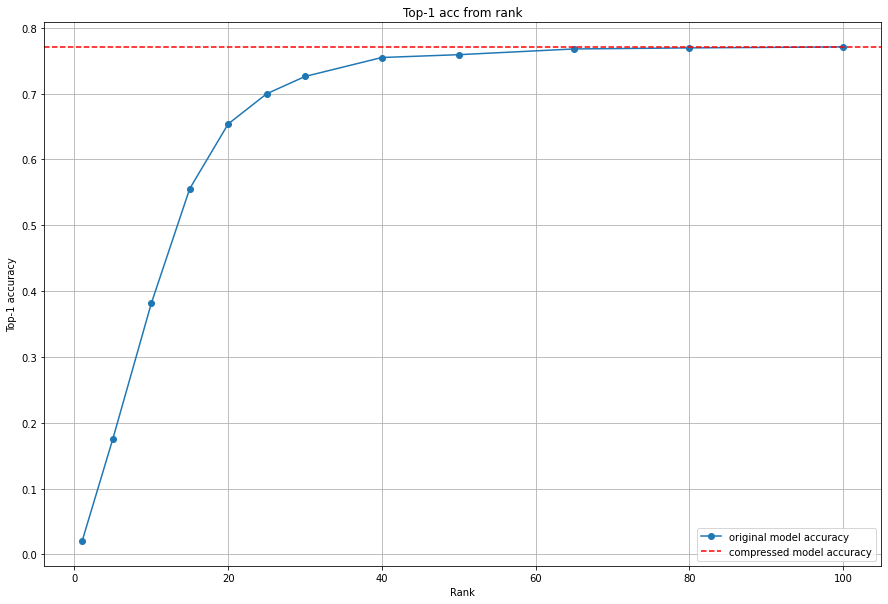

In [ ]:
plt.figure(figsize=(15, 10))
plt.plot(rank_list, acc_list, marker = 'o', label="original model accuracy")
plt.axhline(y=top1_acc_orig, color='r', linestyle='--', label="compressed model accuracy")
plt.grid()
plt.title("Top-1 acc from rank")
plt.xlabel("Rank")
plt.ylabel("Top-1 accuracy")
plt.legend()
plt.show()

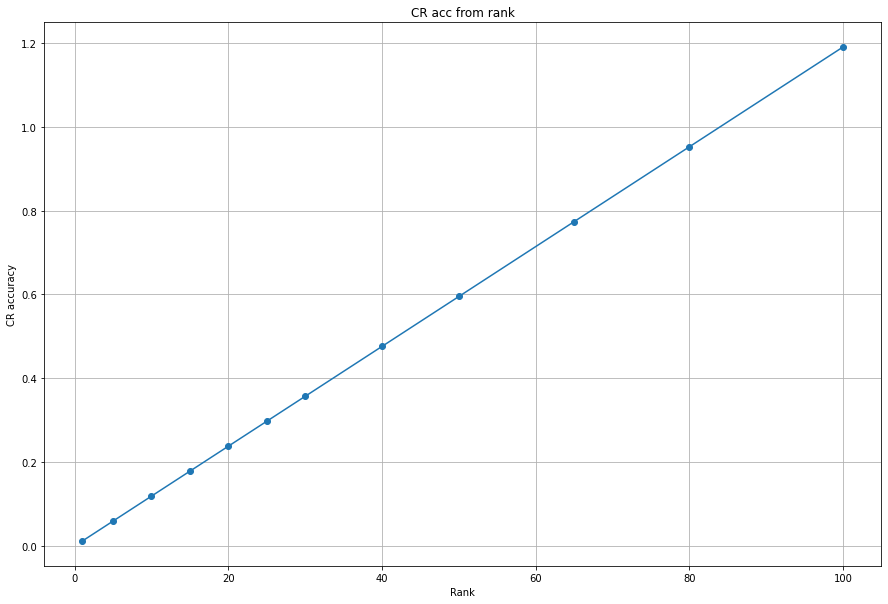

In [ ]:
plt.figure(figsize=(15, 10))
plt.plot(rank_list, cr_list, marker = 'o', label="original model accuracy")
plt.grid()
plt.title("CR acc from rank")
plt.xlabel("Rank")
plt.ylabel("CR accuracy")
# plt.legend()
plt.show()

# 3. Compress Convolutional layer by SVD

We can not apply matrix factorization to convolutional layer directly, because weight represents a 4-dimesional tensor

In [ ]:
model.layer2[0].conv1.weight.shape

torch.Size([128, 64, 3, 3])

## 3.1. Compress one layer

In order to resolve this problem, we will reshape kernel to matrix. Decompose it by Truncated SVD and then reshape obtained matrices back to 4-dimensional tensor.

There are two ways how to do it:

1) **Spatial-SVD**
![**Spatial-SVD**](https://github.com/k-sobolev/m5-forecasting-accuracy/blob/main/Spatial-SVD.PNG?raw=true)

1) **Weight-SVD** 
![**Weight-SVD**](https://github.com/k-sobolev/m5-forecasting-accuracy/blob/main/Weight-SVD.PNG?raw=true)



We will implement **Spatial-SVD**, implementation of **Weight-SVD** will be a part of your home assignment :)


In [ ]:
weight = model.layer2[0].conv1.weight
bias = model.layer2[0].conv1.bias

is_bias = model.layer2[0].conv1.bias is not None 

In [ ]:
is_bias

False

In [ ]:
c_out, c_in, h, w = weight.shape
padding = model.layer2[0].conv1.padding
stride = model.layer2[0].conv1.stride
kernel_size = model.layer2[0].conv1.kernel_size

#change orger of dimensions: C_out, C_in, h, w -> C_out, h, C_in, w
weight_permuted = weight.permute(0, 2, 1, 3)

#reshape to matrix: C_out, h, C_in, w -> C_out x h, C_in x w
weight_reshaped = weight_permuted.reshape(c_out * h, c_in * w).cpu().data.numpy()

# decomposition
U, S, Vt = np.linalg.svd(weight_reshaped, full_matrices=False)

rank = 10
            
w0 = np.dot(np.diag(np.sqrt(S[0:rank])),Vt[0:rank, :])
w1 = np.dot(U[:, 0:rank], np.diag(np.sqrt(S[0:rank])))

conv1 = nn.Conv2d(in_channels=c_in, out_channels=rank,
                      kernel_size=(1, w), bias=False, 
                      stride=(1, stride[1]),
                      padding=(0, padding[1]))
conv1.weight = nn.Parameter(torch.FloatTensor(w0).reshape(rank, c_in, 1, w))

conv2 = nn.Conv2d(in_channels=rank, out_channels=c_out,
                      kernel_size=(h, 1), bias=is_bias, 
                      stride=(stride[0], 1),
                      padding=(padding[0], 0))
conv2.weight = nn.Parameter(torch.FloatTensor(w1).reshape(c_out, h, 
                                                          rank, 1).permute(0, 2,
                                                                           1, 3))

factorized_layer = nn.Sequential(conv1, conv2)

In [ ]:
compressed_model = copy.deepcopy(model)
compressed_model.layer2[0].conv1 = factorized_layer

In [ ]:
compressed_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

In [ ]:
compressed_model.to(device)
top1_acc, top5_acc = get_validation_scores(compressed_model, val_loader, device=device)
print(f'Compressed model. Top 1 acc: {top1_acc:.3f}, Top 5 acc: {top5_acc:.3f}')

  0%|          | 0/40 [00:00<?, ?it/s]

Compressed model. Top 1 acc: 0.612, Top 5 acc: 0.852


In [ ]:
class SVD_Spatial_conv_layer(torch.nn.Module):
    def __init__(self, layer, rank=None):
        super(SVD_Spatial_conv_layer, self).__init__()
        
        self.c_in = layer.in_channels
        self.c_out = layer.out_channels
        self.padding = layer.padding
        self.stride = layer.stride
        self.kernel_size = layer.kernel_size
        self.h = layer.kernel_size[0]
        self.w = layer.kernel_size[1]
        self.is_bias = layer.bias is not None 
        if self.is_bias:
            self.bias = layer.bias

        self.rank = rank
        self.svd_decomposition = self.__replace__(layer)
        
    def __replace__(self, layer):   
        
        weight_reshaped = layer.weight.permute(0, 2, 1, 3).reshape(self.c_out * self.h, 
                                                                   self.c_in * self.w).cpu().data.numpy()
        U, S, Vt = np.linalg.svd(weight_reshaped, full_matrices=False)
            
        w0 = np.dot(np.diag(np.sqrt(S[0:self.rank])),Vt[0:self.rank, :])
        w1 = np.dot(U[:, 0:self.rank], np.diag(np.sqrt(S[0:self.rank])))

        new_layers = [
            nn.Conv2d(in_channels=self.c_in, out_channels=self.rank,
                      kernel_size=(1, self.w), bias=False, 
                      stride=(1, self.stride[1]),
                      padding=(0, self.padding[1])),
            
            nn.Conv2d(in_channels=self.rank, out_channels=self.c_out,
                      kernel_size=(self.h, 1), bias=self.is_bias, 
                      stride=(self.stride[0], 1),
                      padding=(self.padding[0], 0))]

        new_kernels = [torch.FloatTensor(w0).reshape(self.rank, self.c_in, 1, self.w),
                       torch.FloatTensor(w1).reshape(self.c_out, self.h, self.rank, 1).permute(0, 2, 1, 3)]
        
        with torch.no_grad():
            for i in range(len(new_kernels)):
                new_layers[i].weight = nn.Parameter(new_kernels[i].cpu())
                if i == len(new_kernels)-1 and self.is_bias:
                    new_layers[i].bias = nn.Parameter(self.bias)
        
        return nn.Sequential(*new_layers)
    
    def forward(self, x):
        out = self.svd_decomposition(x)
        return out


Visualization of resulting convolution:



![Visualization of resulting convolution](https://ai2-s2-public.s3.amazonaws.com/figures/2017-08-08/62e348e26976c3ef77909b9af9788ebc2509009a/3-Figure1-1.png)



## 3.2. Compress many layers

In [ ]:
def cr_to_svd_rank(layer, decomposition='spatial-svd', cr=2.):
  weight_shape = layer.weight.shape
  cout, cin, kh, kw = weight_shape

  initial_count = cout * cin * kh * kw

  if decomposition == 'spatial-svd':
    rank = initial_count // (cr * (cin * kh + kw * cout))
  elif decomposition == 'weight-svd':
    rank = initial_count // (cr * (cin * kh * kw + cout))
  else:
    print('Wrong decomposiiton name. Should be spatial-svd or weight-svd')
    rank = None

  return int(rank)

def calculate_layer_cr(model_stats, lnames_to_compress, cr=2):
  flops_to_compress = 0
  for lname in lnames_to_compress:
    flops_to_compress += model_stats.flops[lname][0]
  uncompressed_flops = model_stats.total_flops - flops_to_compress
  layer_cr = flops_to_compress * cr / (flops_to_compress + 
                                       uncompressed_flops * (1- cr))
  return layer_cr

In [ ]:
model.to(device)
model_stats = FlopCo(model, img_size = (1, 3, 32, 32), device = device)
lnames_to_compress = [lname for lname, _ in model.named_modules() if 'conv' in lname]
lnames_to_compress = lnames_to_compress[1:]

In [ ]:
lnames_to_compress

['layer1.0.conv1',
 'layer1.0.conv2',
 'layer1.1.conv1',
 'layer1.1.conv2',
 'layer2.0.conv1',
 'layer2.0.conv2',
 'layer2.1.conv1',
 'layer2.1.conv2',
 'layer3.0.conv1',
 'layer3.0.conv2',
 'layer3.1.conv1',
 'layer3.1.conv2',
 'layer4.0.conv1',
 'layer4.0.conv2',
 'layer4.1.conv1',
 'layer4.1.conv2']

In [ ]:
 model_compression_ratio = 8
 layer_cr = calculate_layer_cr(model_stats, lnames_to_compress, cr=model_compression_ratio)

In [ ]:
compressed_model = copy.deepcopy(model)
for lname in lnames_to_compress:
  layer = get_layer_by_name(compressed_model, lname)
  r = cr_to_svd_rank(layer, decomposition='spatial-svd', cr=layer_cr)
  compressed_layer = SVD_Spatial_conv_layer(layer, rank = r)
  replace_conv_layer_by_name(compressed_model, lname, compressed_layer)

In [ ]:
compressed_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): SVD_Spatial_conv_layer(
        (svd_decomposition): Sequential(
          (0): Conv2d(64, 10, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1), bias=False)
          (1): Conv2d(10, 64, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0), bias=False)
        )
      )
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): SVD_Spatial_conv_layer(
        (svd_decomposition): Sequential(
          (0): Conv2d(64, 10, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1), bias=False)
          (1): Conv2d(10, 64, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0), bias=False)
        )
      )
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut)

In [ ]:
compressed_model.to(device)
top1_acc, top5_acc = get_validation_scores(compressed_model, val_loader, device=device)
print(f'Compressed model. Top 1 acc: {top1_acc:.3f}, Top 5 acc: {top5_acc:.3f}')

  0%|          | 0/40 [00:00<?, ?it/s]

Compressed model. Top 1 acc: 0.080, Top 5 acc: 0.234


In [ ]:
compressed_model_stats = FlopCo(compressed_model, img_size = (1, 3, 32, 32), device = device)

model_stats.total_flops / compressed_model_stats.total_flops

7.947028381184692

We have ~8 times FLOPs reduction. Lets check how it will affect the inference speed

In [ ]:
from  time import time
#gpu
times_orig = []
times_compressed = []


with torch.no_grad():
    # warm up
    x = torch.randn(1, 3, 32, 32).to(device)
    model.to(device)
    for i in range(100):
        model(x)

    for i in range(100):
        t0 = time()
        model(x)

        times_orig += [time() - t0]

    compressed_model.to(device)
    # warm up
    for i in range(100):
        compressed_model(x)

    for i in range(100):
        t0 = time()
        compressed_model(x)
        times_compressed += [time() - t0]

print(f"Mean time of original/compressed model: {np.mean(times_orig):.3e}/{np.mean(times_compressed):.3e}")
print(f"Mean ration of original/compressed model: {np.mean(times_orig)/np.mean(times_compressed):.3e}")

Mean time of original/compressed model: 3.802e-03/4.460e-03
Mean ration of original/compressed model: 8.524e-01


In [ ]:
#cpu
times_orig = []
times_compressed = []


with torch.no_grad():
    # warm up
    x = torch.randn(1, 3, 32, 32).to("cpu")
    model.cpu()
    for i in range(100):
        model(x)

    for i in range(100):
        t0 = time()
        model(x)

        times_orig += [time() - t0]

    compressed_model.cpu()
    # warm up
    for i in range(100):
        compressed_model(x)

    for i in range(100):
        t0 = time()
        compressed_model(x)
        times_compressed += [time() - t0]

print(f"Mean time of original/compressed model: {np.mean(times_orig):.3e}/{np.mean(times_compressed):.3e}")
print(f"Mean ration of original/compressed model: {np.mean(times_orig)/np.mean(times_compressed):.3e}")

Mean time of original/compressed model: 2.164e-02/8.324e-03
Mean ration of original/compressed model: 2.600e+00


## 3.3. Fine-tune the model

As we can see, accuracy of our model has dropped significantly. Let's fine-tune it and see how well can we recover the accuracy.

In [ ]:
 optimizer = optim.SGD(compressed_model.parameters(), lr=0.001, weight_decay=0,
                          momentum=0.9)
# scheduler = optim.lr_scheduler.StepLR(optimizer, args.step_epochs, args.lr_factor)
compressed_model.to(device)

for epoch in range(10):
    train(compressed_model, device, train_loader, optimizer)
    top1_acc, top5_acc = get_validation_scores(compressed_model, val_loader, device=device)
    print(f'Epoch: {epoch}, top-1 acc.:{top1_acc}')

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 0, top-1 acc.:0.6829


KeyboardInterrupt: ignored

# 4. Compress convolutional layer by CPD

In this section we will use CPD. An example with TKD can be found in Tensorly tutorials: https://github.com/JeanKossaifi/tensorly-notebooks/blob/master/05_pytorch_backend/cnn_acceleration_tensorly_and_pytorch.ipynb

This part is based on two papers: [Speeding-up Convolutional Neural Networks Using Fine-tuned CP-Decomposition](https://arxiv.org/abs/1412.6553) and [Stable Low-rank Tensor Decomposition for Compression of Convolutional Neural Network](https://arxiv.org/abs/2008.05441)

Convolutional kernel is a 4d array with dimensions responsible for: number of input channels, number of output channels and 2 spatial dimensions.

We can decompose as 4d or 3d tensor.




## 4.1 4D tensor decomposition

The idea is to approximate our 4 dimensional convolutional kernel with a CP decomposition of rank R:

Let $K \in \mathbb{R}^{T\times S \times D\times D}$ be a  kernel tensor, corresponding to convolutional layer with $S$ input channels, $T$ output channels, and $D\times D$  spacial convolution. Using rank-R CP decomposition, one element of kernel $K$ can be represented as follows
\begin{equation*}
    K(t, s, j, i) \cong \sum_{r = 1}^{R}K^{h}(j, r)K^{w}(i, r)K^{s}(s, r)K^{t}(t, r),
\end{equation*}
 where $K^h \in \mathbb{R}^{D\times R}, K^w \in \mathbb{R}^{D\times R}, K^s \in \mathbb{R}^{S\times R}, K^t \in \mathbb{R}^{T\times R}$
where $K^h, K^w, K^s$ and $K^t$ are matrices of sizes $D\times R, D\times R, S\times R$ and $T\times R$, respectively.
Therefore, having an input  $H$ to the convolutional layer, the output tensor $Y$ is calculated as follows
\begin{align*}
        Y(t, h', w') &= \sum_{h = h' - \delta}^{h'+\delta}\sum_{w = w' - \delta}^{w'+\delta}\sum_{s = 1}^SK(t, s, h - h' + \delta, w - w' + \delta)H(s, h, w)
\end{align*}
Substituting kernel expression into the last formula, performing rearrangements and grouping summands, we obtain the following four consecutive expressions for the approximate evaluation of the convolution
\begin{align*}
    Z^1(r, h, w) &= \sum_{s = 1}^S K^s(s, r)H(s, h, w),\\
    Z^2(r, h', w) &= \sum_{h = h' - \delta}^{h'+\delta}K^h(h-h'+\delta, r)Z^1(r, h, w),\\
    Z^3(r, h', w') &= \sum_{w = w' - \delta}^{w'+\delta}K^w(w-w'+\delta, r)Z^2(r, h',  w),\\
    Y(t, h', w') &= \sum_{r = 1}^R K^t(t, r)Z^3(r, h', w'),
\end{align*}
where $\delta = D/2$. 



Visualization of resulting convolution:



![Visualization of resulting convolution](https://ai2-s2-public.s3.amazonaws.com/figures/2017-08-08/62e348e26976c3ef77909b9af9788ebc2509009a/3-Figure1-1.png)


As a result, instead of one big convolution we make 4 light-weight convolutions:

 1. First do a point wise (1x1xS) convolution with the kernel $K(r)$.
 
 This reduces the number of input channels from S to R.
 The convolutions will next be done on a smaller number of channels, making them faster.

 2. Perform two seperable convolutions in the spatial dimensions with $K^x_r,K^y_r$. We can do this in PyTorch using grouped convolutions.

    **Like in [mobilenets](https://arxiv.org/abs/1704.04861) the convolutions are depthwise seperable, done in each channel separately.**
    **Unlike mobilenets the convolutions are also separable in the spatial dimensions.**

 3. Do another pointwise convolution to change the number of channels from R to T
 4. Finally, add the bias.
 
 
Notice the combination of pointwise and depthwise convolutions like in mobilenets. While with mobilenets you have to train a network from scratch to get this structure, here we can decompose an existing layer into this form.

As with mobile nets, to get the most speedup you will need a platform that has an efficient implementation of depthwise separable convolutions.

In [ ]:
conv_kernel = model.layer2[0].conv1.weight

rank = 7

weight, [last, first, vertical, horizontal] = \
            parafac(conv_kernel, rank=rank, init='svd')

print('Weight: ', weight)

print('Shapes: first - {}, vertical - {}, horizontal - {}, last - {}'.format(first.shape, vertical.shape, horizontal.shape, last.shape))

/usr/local/lib/python3.7/dist-packages/tensorly/backend/pytorch_backend.py:127: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
  solution, _ = torch.solve(matrix2, matrix1)


Weight:  tensor([1., 1., 1., 1., 1., 1., 1.], requires_grad=True)
Shapes: first - torch.Size([64, 7]), vertical - torch.Size([3, 7]), horizontal - torch.Size([3, 7]), last - torch.Size([128, 7])


In [ ]:
print(weight)

tensor([1., 1., 1., 1., 1., 1., 1.], device='cuda:0', requires_grad=True)


Let us make a convenient class to implement this seqience of 4 convolutions:

In [ ]:
class CPD4_layer(torch.nn.Module):
    
    def __init__(self, layer, rank):
        
        super(CPD4_layer, self).__init__()
        self.rank = rank
        self.cin = layer.in_channels
        self.cout = layer.out_channels
        self.padding = layer.padding
        self.stride = layer.stride
        self.dilation = layer.dilation
        self.kernel_size = layer.kernel_size
        self.is_bias = layer.bias is not None
        if self.is_bias:
            self.bias = layer.bias
        
        self.cp_decomposition = self.__replace__(layer.weight.data.cpu())
        
    def __replace__(self, initial_kernel):
        
        weight, [last, first, vertical, horizontal] = \
                parafac(initial_kernel, rank=self.rank, init='svd')

        
        new_layers = [
            nn.Conv2d(in_channels=self.cin, bias=False, 
                      out_channels=self.rank, kernel_size = (1, 1)),

            nn.Conv2d(in_channels = self.rank, 
                                    out_channels=self.rank,
                                    kernel_size = (self.kernel_size[0], 1),
                                    groups = self.rank, 
                                    padding = (self.padding[0],0),
                                    stride = (self.stride[0], 1)),
                          
            nn.Conv2d(in_channels = self.rank,
                                    out_channels=self.rank,
                                    kernel_size = (1, self.kernel_size[1]),
                                    groups = self.rank,
                                    padding = (0, self.padding[1]),
                                    stride = (1, self.stride[1])),
                      
            nn.Conv2d(in_channels = self.rank,
                                    bias=self.is_bias,
                                    out_channels = self.cout, 
                                    kernel_size = (1, 1))
        ]


        new_kernels = [ torch.FloatTensor(torch.reshape(first.cpu().T, [self.rank, self.cin, 1, 1])),
                        torch.FloatTensor(torch.reshape(horizontal.cpu().T, (self.rank, 1, self.kernel_size[0], 1))),
                        torch.FloatTensor(torch.reshape(vertical.cpu().T, [self.rank, 1, 1, self.kernel_size[1]])),
                        torch.FloatTensor(torch.reshape(last.cpu(), [self.cout, self.rank, 1, 1]))#.contiguous()
        ]
        with torch.no_grad():
            for i in range(len(new_kernels)):
                new_layers[i].weight = nn.Parameter(new_kernels[i])
                if i == len(new_kernels)-1 and self.is_bias:
                    new_layers[i].bias = nn.Parameter(self.bias)
        
        return nn.Sequential(*new_layers)
    
    def forward(self, x):
        out = self.cp_decomposition(x)
        return out

In [ ]:
model.cpu()
cpd4_factorized_conv2 = CPD4_layer(model.layer1[0].conv2, rank =5)

In [ ]:
cpd4_factorized_conv2

CPD4_layer(
  (cp_decomposition): Sequential(
    (0): Conv2d(64, 5, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): Conv2d(5, 5, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0), groups=5)
    (2): Conv2d(5, 5, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1), groups=5)
    (3): Conv2d(5, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
  )
)

### Measure inference time on CPU



In [ ]:
dummy_data = torch.randn((1, 64, 224, 224)).cpu()

In [ ]:
%timeit -r 50 -n 10  model.layer1[0].conv2(dummy_data)

10 loops, best of 50: 46.1 ms per loop


In [ ]:
%timeit -r 50 -n 10  cpd4_factorized_conv2(dummy_data)

10 loops, best of 50: 6.7 ms per loop


## 4.2. 3D tensor decomposition

In practice, it is often more convenient to compress convolutional layer as 3D tensor by reshaping it to $S \times T \times D^2$ tensor. This allowes to have more balanced dimensions and less layers in the factorized layer - 3.

Let $K \in \mathbb{R}^{T\times S \times D^2}$ be a  kernel tensor, corresponding to convolutional layer with $S$ input channels, $T$ output channels, and $D\times D$  spacial convolution. Using rank-R CP decomposition, one element of kernel $K$ can be represented as follows
\begin{equation*}
    A(t, s, j) \cong \sum_{r = 1}^{R}A^{hw}(j, r)K^{s}(s, r)K^{t}(t, r),
\end{equation*}
Then, in order to reshape convolutional layer back to original shape, we reshape factor-matrix $A^{hw}$ to a tensor $K^{hw}$ of shape $D \times D \times R$.
\begin{equation*}
    K(t, s, j, i) \cong \sum_{r = 1}^{R}K^{hw}(j, i, r)K^{s}(s, r)K^{t}(t, r),
\end{equation*}
% where $K^{hw} \in \mathbb{R}^{D^2\times R}, K^s \in \mathbb{R}^{S\times R}, K^t \in \mathbb{R}^{T\times R}$
where $K^{hw}, K^s$ and $K^t$ are matrices of sizes $D^2\times R, S\times R$ and $T\times R$, respectively.
Therefore, having an input  $H$ to the convolutional layer, the output tensor $Y$ is calculated as follows
\begin{align*}
        Y(t, h', w') &= \sum_{h = h' - \delta}^{h'+\delta}\sum_{w = w' - \delta}^{w'+\delta}\sum_{s = 1}^SK(t, s, h - h' + \delta, w - w' + \delta)H(s, h, w)
\end{align*}
Substituting kernel expression into the last formula, performing rearrangements and grouping summands, we obtain the following four consecutive expressions for the approximate evaluation of the convolution
\begin{align*}
    Z^1(r, h, w) &= \sum_{s = 1}^S K^s(s, r)H(s, h, w),\\
    Z^2(r, h', w') &= \sum_{h = h' - \delta}^{h'+\delta}\sum_{w = w' - \delta}^{w'+\delta}K^{hw}(h - h' + \delta, w - w' + \delta, r)Z^1(r, h, w),\\
    Y(t, h', w') &= \sum_{r = 1}^R K^t(t, r)Z^2(r, h', w'),
\end{align*}
where $\delta = D/2$. 


As a result, instead of one big convolution we make 4 light-weight convolutions:

 1. First do a point wise (1x1xS) convolution with the kernel $K(r)$.
 
 This reduces the number of input channels from S to R.
 The convolutions will next be done on a smaller number of channels, making them faster.

 2. Perform seperable convolutions in the spatial dimensions with $K^{hw}_r$. We can do this in PyTorch using grouped convolutions.

    **Like in [mobilenets](https://arxiv.org/abs/1704.04861) the convolutions are depthwise seperable, done in each channel separately.**

 3. Do another pointwise convolution to change the number of channels from R to T
 4. Finally, add the bias.

In [ ]:
shape = conv_kernel.shape
new_shape = shape[0], shape[1], shape[2]*shape[3]
reshaped_kernel = conv_kernel.reshape(new_shape)
reshaped_kernel.shape

torch.Size([128, 64, 9])

In [ ]:
rank = 7

weight, [last, first, spatial] = \
        parafac(reshaped_kernel, rank=rank, init='svd')

print('Weight: ', weight)

print('Shapes: first - {}, vertical - {}, spatial - {}'.format(first.shape, spatial.shape, first.shape))

Weight:  tensor([1., 1., 1., 1., 1., 1., 1.], requires_grad=True)
Shapes: first - torch.Size([64, 7]), vertical - torch.Size([9, 7]), spatial - torch.Size([64, 7])


In [ ]:
class CPD3_layer(torch.nn.Module):
    
    def __init__(self, layer, rank):
        
        super(CPD3_layer, self).__init__()
        self.rank = rank
            
        self.cin = layer.in_channels
        self.cout = layer.out_channels
        self.padding = layer.padding
        self.stride = layer.stride
        self.dilation = layer.dilation
        self.kernel_size = layer.kernel_size
        self.is_bias = layer.bias is not None
        if self.is_bias:
            self.bias = layer.bias

        self.cp_decomposition = self.__replace__(layer.weight.data.cpu())
        
    def __replace__(self, initial_kernel):
        
        shape = initial_kernel.shape
        new_shape = shape[0], shape[1], shape[2]*shape[3]
        reshaped_kernel = initial_kernel.reshape(new_shape)

        weight, [last, first, spatial] = \
            parafac(reshaped_kernel, rank=self.rank, init='svd')
            
       
        # expected order of factors is the following [cout,rank], [cin,rank], [k*k,rank]

        new_layers = [
            nn.Conv2d(in_channels=self.cin, bias=False, 
                      out_channels=self.rank, kernel_size = (1, 1)),
            nn.Conv2d(in_channels = self.rank, 
                                    out_channels=self.rank,
                                    kernel_size = self.kernel_size,
                                    groups = self.rank, 
                                    padding = self.padding,
                                    dilation = self.dilation,
                                    bias=False,
                                    stride = self.stride),
            nn.Conv2d(in_channels = self.rank,
                                    bias=self.is_bias,
                                    out_channels = self.cout, 
                                    kernel_size = (1, 1))
        ]

        new_kernels = [ torch.FloatTensor(np.reshape(first.cpu().T, [self.rank, self.cin, 1, 1])),
                        torch.FloatTensor(np.reshape(spatial.cpu().T, [self.rank, 1, *self.kernel_size])),
                        torch.FloatTensor(np.reshape(last.cpu(), [self.cout, self.rank, 1, 1]))#.contiguous()
        ]

        with torch.no_grad():
            for i in range(len(new_kernels)):
                new_layers[i].weight = nn.Parameter(new_kernels[i])
                if i == len(new_kernels)-1 and self.is_bias:
                    new_layers[i].bias = nn.Parameter(self.bias)
        
        return nn.Sequential(*new_layers)
    
    def forward(self, x):
        out = self.cp_decomposition(x)
        return out

In [ ]:
model.cpu()
cpd3_factorized_conv2 = CPD3_layer(model.layer1[0].conv2, rank=5)

### Measure inference time on CPU


In [ ]:
dummy_data = torch.randn((1, 64, 224, 224)).cpu()

In [ ]:
%timeit -r 50 -n 10  model.layer1[0].conv2(dummy_data)

10 loops, best of 50: 52.2 ms per loop


In [ ]:
%timeit -r 50 -n 10  cpd3_factorized_conv2(dummy_data)

10 loops, best of 50: 10.5 ms per loop


## 4.3. Replace original layer in model

In [ ]:
compressed_model = copy.deepcopy(model)
compressed_model.conv1 = CPD3_layer(compressed_model.conv1, rank=2)

In [ ]:
compressed_model

ResNet(
  (conv1): CPD3_layer(
    (cp_decomposition): Sequential(
      (0): Conv2d(3, 2, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2, bias=False)
      (2): Conv2d(2, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
  )
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(6

# 5. MUSCO framework

[MUSCO](https://github.com/musco-ai/musco-pytorch)  is a framework for automatic NN compression by LR decomposition. In addition, it provides a decomposition rank selection by iterative compression. Instead of selecting rank, we can iteratively reduce it beginning from full rank and ending with really small ranks. In addition, this iterative procedure allowes to reduce end up with smaller network with higher accuracy. 

In [ ]:
!pip install musco-pytorch

     |████████████████████████████████| 48 kB 2.7 MB/s 
     |████████████████████████████████| 17.3 MB 8.7 MB/s 
     |████████████████████████████████| 25.2 MB 589 kB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
xarray 0.18.2 requires numpy>=1.17, but you have numpy 1.16.6 which is incompatible.
pywavelets 1.2.0 requires numpy>=1.17.3, but you have numpy 1.16.6 which is incompatible.
pyerfa 2.0.0.1 requires numpy>=1.17, but you have numpy 1.16.6 which is incompatible.
kapre 0.3.6 requires numpy>=1.18.5, but you have numpy 1.16.6 which is incompatible.
jaxlib 0

## 5.1. CPD-4 example

In [ ]:
from musco.pytorch import CompressorVBMF, CompressorPR, CompressorManual

In [ ]:
device = 'cuda'
model.to(device)
model_stats = FlopCo(model, img_size = (1, 3, 32, 32), device = device)

In [ ]:
lnames = list(model_stats.flops.keys())
lnames_to_compress = [lname for lname, _ in model.named_modules() if 'conv' in lname]
lnames_to_compress = lnames_to_compress[1:]
lnames_to_compress

['layer1.0.conv1',
 'layer1.0.conv2',
 'layer1.1.conv1',
 'layer1.1.conv2',
 'layer2.0.conv1',
 'layer2.0.conv2',
 'layer2.1.conv1',
 'layer2.1.conv2',
 'layer3.0.conv1',
 'layer3.0.conv2',
 'layer3.1.conv1',
 'layer3.1.conv2',
 'layer4.0.conv1',
 'layer4.0.conv2',
 'layer4.1.conv1',
 'layer4.1.conv2']

In [ ]:
layer_cr

8.926052385626594

In [ ]:
param_reduction_rates = {lname: layer_cr for lname in lnames_to_compress}

compressor = CompressorPR(model,
                          model_stats,
                          conv2d_nn_decomposition='cp4',
                          ft_every=len(lnames_to_compress), 
                          param_reduction_rates=param_reduction_rates,
                          nglobal_compress_iters=1)

compressor.lnames = lnames_to_compress

compressor.compression_step()

layer1.0.conv1 cp4
layer1.0.conv2 cp4
layer1.1.conv1 cp4
layer1.1.conv2 cp4
layer2.0.conv1 cp4
layer2.0.conv2 cp4
layer2.1.conv1 cp4
layer2.1.conv2 cp4
layer3.0.conv1 cp4
layer3.0.conv2 cp4
layer3.1.conv1 cp4
layer3.1.conv2 cp4
layer4.0.conv1 cp4
layer4.0.conv2 cp4
layer4.1.conv1 cp4
layer4.1.conv2 cp4


In [ ]:
compressed_model = compressor.compressed_model

compressed_model.to(device)
top1_acc, top5_acc = get_validation_scores(compressed_model, val_loader, device=device)
print(f'Compressed model. Top 1 acc: {top1_acc:.3f}, Top 5 acc: {top5_acc:.3f}')

  0%|          | 0/40 [00:00<?, ?it/s]

Compressed model. Top 1 acc: 0.480, Top 5 acc: 0.758


In [ ]:
optimizer = optim.SGD(compressed_model.parameters(), lr=0.001, weight_decay=0,
                          momentum=0.9)
# scheduler = optim.lr_scheduler.StepLR(optimizer, args.step_epochs, args.lr_factor)
compressed_model.to(device)

for epoch in range(10):
    train(compressed_model, device, train_loader, optimizer)
    top1_acc, top5_acc = get_validation_scores(compressed_model, val_loader, device=device)
    print(f'Epoch: {epoch}, top-1 acc.:{top1_acc}')

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 0, top-1 acc.:0.0311


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1, top-1 acc.:0.0467


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 2, top-1 acc.:0.0984


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 3, top-1 acc.:0.1059


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 4, top-1 acc.:0.1448


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 5, top-1 acc.:0.0871


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 6, top-1 acc.:0.1598


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 7, top-1 acc.:0.1538


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 8, top-1 acc.:0.1875


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 9, top-1 acc.:0.1845


## 5.2. Tucker-2 example

Tucker-2 decomposition factorizes a 4-D convolutional kernel in a core tensor and two factor matrices:

$$
\mathcal{K}_{i, j, s, t}=\sum_{r_{3}=1}^{R_{3}} \sum_{r_{4}=1}^{R_{4}} \mathcal{C}_{i, j, r_{3}, r_{4}} U_{s, r_{3}}^{(3)} U_{t, r_{4}}^{(4)}
$$

As a result, we can replace initial layer by three conv layers:

$$
\begin{aligned}
\mathcal{Z}_{h, w, r_{3}} &=\sum_{s=1}^{S} U_{s, r_{3}}^{(3)} \mathcal{X}_{h, w, s}, \\
\mathcal{Z}_{h^{\prime}, w^{\prime}, r_{4}}^{\prime} &=\sum_{i=1}^{D} \sum_{j=1}^{D} \sum_{r_{3}=1}^{R_{3}} \mathcal{C}_{i, j, r_{3}, r_{4}} \mathcal{Z}_{h_{i}, w_{j}, r_{3}}, \\
\mathcal{Y}_{h^{\prime}, w^{\prime}, t} &=\sum_{r_{4}=1}^{R_{4}} U_{t, r_{4}}^{(4)} \mathcal{Z}_{h^{\prime}, w^{\prime}, r_{4}}^{\prime},
\end{aligned}
$$

In case of 3x3 conv with $C_{in}$ and $C_{out}$, we will have 3 convolutional layers:

1) 1x1 conv that projects $C_{in}$  to $R_3$

2) 3x3 conv that changes $R_3$ to $R_4$

3) 1x1 conv that projects $R_4$  to $C_{out}$

![Visualization of resulting convolution](https://media.arxiv-vanity.com/render-output/4687611/x1.png)


In [ ]:
compressor = CompressorPR(model,
                          model_stats,
                          conv2d_nn_decomposition='tucker2',
                          ft_every=len(lnames_to_compress), 
                          param_reduction_rates=param_reduction_rates,
                          nglobal_compress_iters=1)

compressor.lnames = lnames_to_compress

compressor.compression_step()

layer1.0.conv1 tucker2
layer1.0.conv2 tucker2
layer1.1.conv1 tucker2
layer1.1.conv2 tucker2
layer2.0.conv1 tucker2
layer2.0.conv2 tucker2
layer2.1.conv1 tucker2
layer2.1.conv2 tucker2
layer3.0.conv1 tucker2
layer3.0.conv2 tucker2
layer3.1.conv1 tucker2
layer3.1.conv2 tucker2
layer4.0.conv1 tucker2
layer4.0.conv2 tucker2
layer4.1.conv1 tucker2
layer4.1.conv2 tucker2


In [ ]:
compressed_model = compressor.compressed_model

compressed_model.to(device)
top1_acc, top5_acc = get_validation_scores(compressed_model, val_loader, device=device)
compressed_model_stats = FlopCo(compressed_model,
                                img_size = (1, 3, 32, 32), 
                                device = device)
print(f'Compressed model. Top 1 acc: {top1_acc:.3f}, Top 5 acc: {top5_acc:.3f}')
print(f'Compressed model FLOPs: {compressed_model_stats.total_flops}')

top1_acc, top5_acc = get_validation_scores(compressor.compressed_model, 
                                             val_loader, device=device)


  0%|          | 0/40 [00:00<?, ?it/s]

Compressed model. Top 1 acc: 0.295, Top 5 acc: 0.602
Compressed model FLOPs: 139803872


  0%|          | 0/40 [00:00<?, ?it/s]

In [ ]:
optimizer = optim.SGD(compressed_model.parameters(), lr=0.0001, weight_decay=0,
                          momentum=0.9)
# scheduler = optim.lr_scheduler.StepLR(optimizer, args.step_epochs, args.lr_factor)
compressed_model.to(device)

for epoch in range(10):
    train(compressed_model, device, train_loader, optimizer)
    top1_acc, top5_acc = get_validation_scores(compressed_model, val_loader, device=device)
    print(f'Epoch: {epoch}, top-1 acc.:{top1_acc}')

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 0, top-1 acc.:0.6564


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1, top-1 acc.:0.6719


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 2, top-1 acc.:0.6792


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 3, top-1 acc.:0.6848


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 4, top-1 acc.:0.6879


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 5, top-1 acc.:0.6922


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 6, top-1 acc.:0.6934


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 7, top-1 acc.:0.6952


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 8, top-1 acc.:0.6994


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 9, top-1 acc.:0.7024


### Iterative Tucker-2

In [ ]:
compressor = CompressorPR(model,
                          model_stats,
                          conv2d_nn_decomposition='tucker2',
                          ft_every=len(lnames_to_compress), 
                          param_reduction_rates=param_reduction_rates,
                          nglobal_compress_iters=2)

compressor.lnames = lnames_to_compress

In [ ]:
while not compressor.done:
  compressor.compression_step()

  # compressed_model = compressor.compressed_model

  compressor.compressed_model.to(device)
  top1_acc, top5_acc = get_validation_scores(compressor.compressed_model, 
                                             val_loader, device=device)
  compressed_model_stats = FlopCo(compressor.compressed_model, 
                                  img_size = (1, 3, 32, 32), 
                                  device = device)
  print(f'Compressed model. Top 1 acc: {top1_acc:.3f}, Top 5 acc: {top5_acc:.3f}')
  print(f'Compressed model FLOPs: {compressed_model_stats.total_flops}')

  optimizer = optim.SGD(compressor.compressed_model.parameters(), lr=0.0001, weight_decay=0,
                          momentum=0.9)
  # scheduler = optim.lr_scheduler.StepLR(optimizer, args.step_epochs, args.lr_factor)
  compressor.compressed_model.to(device)

  for epoch in range(5):
      train(compressor.compressed_model, device, train_loader, optimizer)
      top1_acc, top5_acc = get_validation_scores(compressor.compressed_model, val_loader, device=device)
      print(f'Epoch: {epoch}, top-1 acc.:{top1_acc}')

layer1.0.conv1 tucker2
layer1.0.conv2 tucker2
layer1.1.conv1 tucker2
layer1.1.conv2 tucker2
layer2.0.conv1 tucker2
layer2.0.conv2 tucker2
layer2.1.conv1 tucker2
layer2.1.conv2 tucker2
layer3.0.conv1 tucker2
layer3.0.conv2 tucker2
layer3.1.conv1 tucker2
layer3.1.conv2 tucker2
layer4.0.conv1 tucker2
layer4.0.conv2 tucker2
layer4.1.conv1 tucker2
layer4.1.conv2 tucker2


  0%|          | 0/40 [00:00<?, ?it/s]

Compressed model. Top 1 acc: 0.295, Top 5 acc: 0.602
Compressed model FLOPs: 139803872


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 0, top-1 acc.:0.657


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1, top-1 acc.:0.6736
